# Capstone – Module 20.1: Initial Report & EDA

## Predicting Priority Date Movement for EB-2 and EB-3 India

This notebook performs data cleaning, exploratory data analysis (EDA),
feature engineering, and builds a baseline regression model to predict
monthly priority date movement for EB-2 and EB-3 India, based on historical
Visa Bulletin data.


In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

sns.set(style="whitegrid")
pd.set_option("display.max_columns", None)

print("Libraries imported.")

Libraries imported.


In [8]:
data_path = "../data/EB2_EB3_India_visa_bulletin.csv"
df_raw = pd.read_csv(data_path)

df_raw.head()
df_raw.columns


Index(['Year', 'Month', 'Bulletin', 'EB2-FA', 'EB3-FA', 'EB2-DOF', 'EB3-DOF',
       'EB2-AOS', 'EB3-AOS', 'EB2 DOF Honored?', 'Difference EB2 AOS',
       'EB3 DOF Honored?', 'Difference EB3 AOS'],
      dtype='object')

In [11]:
# Make a working copy
df = df_raw.copy()

# Convert the Bulletin column (e.g., '1-Oct-20') to a proper datetime
# Format in the CSV is 'day-Mon-YY', e.g., 1-Oct-20 → %d-%b-%y
df["bulletin_date"] = pd.to_datetime(df["Bulletin"], format="%d-%b-%y", errors="coerce")

# Melt EB2 and EB3 Final Action Dates into rows
long = df.melt(
    id_vars=["bulletin_date"],
    value_vars=["EB2-FA", "EB3-FA"],   # using Final Action Dates
    var_name="category_raw",
    value_name="cutoff_str"
)

long.head()

,bulletin_date,category_raw,cutoff_str
0,2020-10-01,EB2-FA,1-Sep-09
1,2020-09-01,EB2-FA,8-Jul-09
2,2020-08-01,EB2-FA,8-Jul-09
3,2020-07-01,EB2-FA,8-Jul-09
4,2020-06-01,EB2-FA,12-Jun-09


In [12]:
# Map category_raw → clean category labels
cat_map = {
    "EB2-FA": "EB2",
    "EB3-FA": "EB3"
}
long["category"] = long["category_raw"].map(cat_map)

# Keep only EB2 / EB3 rows (should already be)
long = long[long["category"].isin(["EB2", "EB3"])].copy()

# Parse the cutoff_str into datetime
# Format is again 'day-Mon-YY' like '1-Sep-09'
def parse_cutoff(s):
    if pd.isna(s):
        return pd.NaT
    s = str(s).strip()
    if s.upper() in ["C", "U", "N/A", ""]:
        return pd.NaT
    try:
        return pd.to_datetime(s, format="%d-%b-%y")
    except Exception:
        # fallback generic parser
        try:
            return pd.to_datetime(s)
        except Exception:
            return pd.NaT

long["cutoff_date"] = long["cutoff_str"].apply(parse_cutoff)

# Add country
long["country"] = "India"

# Final cleaned dataset
df_clean = long[["bulletin_date", "category", "cutoff_date", "country"]].copy()
df_clean = df_clean.sort_values(["category", "bulletin_date"]).reset_index(drop=True)

df_clean.head()


,bulletin_date,category,cutoff_date,country
0,2016-02-01,EB2,2008-08-01,India
1,2016-03-01,EB2,2008-10-15,India
2,2016-04-01,EB2,2008-11-08,India
3,2016-05-01,EB2,2008-11-22,India
4,2016-06-01,EB2,2004-10-01,India


In [13]:
# Compute movement in days between consecutive bulletins
df_clean = df_clean.sort_values(["category", "bulletin_date"]).reset_index(drop=True)
df_clean["cutoff_lag"] = df_clean.groupby("category")["cutoff_date"].shift(1)
df_clean["movement_days"] = (df_clean["cutoff_date"] - df_clean["cutoff_lag"]).dt.days

# Drop first rows with undefined movement
df_model = df_clean.dropna(subset=["movement_days"]).copy()

# Time features
df_model["year"] = df_model["bulletin_date"].dt.year
df_model["month"] = df_model["bulletin_date"].dt.month

# Lag / rolling features
df_model = df_model.sort_values(["category", "bulletin_date"]).reset_index(drop=True)
df_model["movement_lag1"] = df_model.groupby("category")["movement_days"].shift(1)
df_model["movement_lag2"] = df_model.groupby("category")["movement_days"].shift(2)
df_model["movement_roll3"] = (
    df_model.groupby("category")["movement_days"]
            .rolling(3)
            .mean()
            .reset_index(level=0, drop=True)
)

df_model["category_encoded"] = df_model["category"].map({"EB2": 0, "EB3": 1})
df_model = df_model.dropna(subset=["movement_lag1", "movement_lag2", "movement_roll3"])

df_model.head()


,bulletin_date,category,cutoff_date,country,cutoff_lag,movement_days,year,month,movement_lag1,movement_lag2,movement_roll3,category_encoded
2,2016-05-01,EB2,2008-11-22,India,2008-11-08,14.0,2016,5,24.0,75.0,37.666667,0
3,2016-06-01,EB2,2004-10-01,India,2008-11-22,-1513.0,2016,6,14.0,24.0,-491.666667,0
4,2016-07-01,EB2,2004-11-01,India,2004-10-01,31.0,2016,7,-1513.0,14.0,-489.333333,0
5,2016-08-01,EB2,2004-11-15,India,2004-11-01,14.0,2016,8,31.0,-1513.0,-489.333333,0
6,2016-09-01,EB2,2005-02-22,India,2004-11-15,99.0,2016,9,14.0,31.0,48.000000,0


In [16]:
df = df_raw.copy()

# Convert the Bulletin column like "1-Oct-20" to datetime
df["bulletin_date"] = pd.to_datetime(df["Bulletin"], format="%d-%b-%y", errors="coerce")

# Melt the EB2 and EB3 Final Action Dates into rows:
long = df.melt(
    id_vars=["bulletin_date"],
    value_vars=["EB2-FA", "EB3-FA"],   # only EB2 & EB3 Final Action for now
    var_name="category_raw",
    value_name="cutoff_str"
)

# Map EB2-FA → EB2, EB3-FA → EB3
long["category"] = long["category_raw"].map({
    "EB2-FA": "EB2",
    "EB3-FA": "EB3"
})

# Parse cutoff dates from strings like "1-Sep-09"
def parse_cutoff(x):
    if pd.isna(x):
        return pd.NaT
    x = str(x).strip()
    if x.upper() in ["C", "U", "N/A"]:
        return pd.NaT
    try:
        return pd.to_datetime(x, format="%d-%b-%y")
    except:
        return pd.NaT

long["cutoff_date"] = long["cutoff_str"].apply(parse_cutoff)

# Add India as fixed country
long["country"] = "India"

# Final cleaned dataset
df_clean = long[["bulletin_date", "category", "cutoff_date", "country"]].copy()
df_clean = df_clean.sort_values(["category", "bulletin_date"]).reset_index(drop=True)

df_clean.head()


,bulletin_date,category,cutoff_date,country
0,2016-02-01,EB2,2008-08-01,India
1,2016-03-01,EB2,2008-10-15,India
2,2016-04-01,EB2,2008-11-08,India
3,2016-05-01,EB2,2008-11-22,India
4,2016-06-01,EB2,2004-10-01,India


In [19]:
# Load raw dataframe
df_raw = pd.read_csv("../data/EB2_EB3_India_visa_bulletin.csv")
df = df_raw.copy()

# Convert bulletin date (format = '1-Oct-20')
df["bulletin_date"] = pd.to_datetime(df["Bulletin"], format="%d-%b-%y", errors="coerce")

# Melt EB2/EB3 Final Action dates into rows
long = df.melt(
    id_vars=["bulletin_date"],
    value_vars=["EB2-FA", "EB3-FA"],
    var_name="category_raw",
    value_name="cutoff_str"
)

# Map categories
long["category"] = long["category_raw"].map({
    "EB2-FA": "EB2",
    "EB3-FA": "EB3"
})

# Parse cutoff dates
def parse_cutoff(x):
    if pd.isna(x):
        return pd.NaT
    x = str(x).strip()
    if x.upper() in ["C", "U", "N/A"]:
        return pd.NaT
    try:
        return pd.to_datetime(x, format="%d-%b-%y")
    except:
        return pd.NaT

long["cutoff_date"] = long["cutoff_str"].apply(parse_cutoff)

# ---- NOW IT IS SAFE TO CLEAN THE DATA ----
print("Missing values before cleaning:")
print(long[["bulletin_date", "cutoff_date", "category"]].isna().sum())

df_clean = long.dropna(subset=["bulletin_date", "cutoff_date", "category"])
df_clean = df_clean.drop_duplicates()

print("\nAfter cleaning:")
print(df_clean[["bulletin_date", "cutoff_date", "category"]].isna().sum())
print("Shape:", df_clean.shape)

df_clean.head()


Missing values before cleaning:
bulletin_date    0
cutoff_date      0
category         0
dtype: int64

After cleaning:
bulletin_date    0
cutoff_date      0
category         0
dtype: int64
Shape: (114, 5)


,bulletin_date,category_raw,cutoff_str,category,cutoff_date
0,2020-10-01,EB2-FA,1-Sep-09,EB2,2009-09-01
1,2020-09-01,EB2-FA,8-Jul-09,EB2,2009-07-08
2,2020-08-01,EB2-FA,8-Jul-09,EB2,2009-07-08
3,2020-07-01,EB2-FA,8-Jul-09,EB2,2009-07-08
4,2020-06-01,EB2-FA,12-Jun-09,EB2,2009-06-12


In [20]:
# Create time-based features
df["year"] = df["bulletin_date"].dt.year
df["month"] = df["bulletin_date"].dt.month

df.head()

,Year,Month,Bulletin,EB2-FA,EB3-FA,EB2-DOF,EB3-DOF,EB2-AOS,EB3-AOS,EB2 DOF Honored?,Difference EB2 AOS,EB3 DOF Honored?,Difference EB3 AOS,bulletin_date,year,month
0,2020,October,1-Oct-20,1-Sep-09,15-Jan-10,15-May-11,1-Jan-15,15-May-11,1-Jan-15,True,0,True,0,2020-10-01,2020,10
1,2020,September,1-Sep-20,8-Jul-09,1-Oct-09,15-Aug-09,1-Feb-10,8-Jul-09,1-Oct-09,False,38,False,123,2020-09-01,2020,9
2,2020,August,1-Aug-20,8-Jul-09,1-Oct-09,15-Aug-09,1-Feb-10,8-Jul-09,1-Oct-09,False,38,False,123,2020-08-01,2020,8
3,2020,July,1-Jul-20,8-Jul-09,1-Jun-09,15-Aug-09,1-Feb-10,8-Jul-09,1-Jun-09,False,38,False,245,2020-07-01,2020,7
4,2020,June,1-Jun-20,12-Jun-09,1-Apr-09,1-Jul-09,1-Feb-10,12-Jun-09,1-Apr-09,False,19,False,306,2020-06-01,2020,6


In [22]:
# Compute movement in days between consecutive bulletins for each category
df_model = df_clean.sort_values(["category", "bulletin_date"]).reset_index(drop=True)

df_model["cutoff_lag"] = df_model.groupby("category")["cutoff_date"].shift(1)
df_model["movement_days"] = (df_model["cutoff_date"] - df_model["cutoff_lag"]).dt.days

df_model.head()


,bulletin_date,category_raw,cutoff_str,category,cutoff_date,cutoff_lag,movement_days
0,2016-02-01,EB2-FA,1-Aug-08,EB2,2008-08-01,NaT,NaN
1,2016-03-01,EB2-FA,15-Oct-08,EB2,2008-10-15,2008-08-01,75.0
2,2016-04-01,EB2-FA,8-Nov-08,EB2,2008-11-08,2008-10-15,24.0
3,2016-05-01,EB2-FA,22-Nov-08,EB2,2008-11-22,2008-11-08,14.0
4,2016-06-01,EB2-FA,1-Oct-04,EB2,2004-10-01,2008-11-22,-1513.0


In [23]:
# Drop first rows (no movement)
df_model = df_model.dropna(subset=["movement_days"]).copy()

# Time features
df_model["year"] = df_model["bulletin_date"].dt.year
df_model["month"] = df_model["bulletin_date"].dt.month

# Lag features
df_model = df_model.sort_values(["category", "bulletin_date"]).reset_index(drop=True)
df_model["movement_lag1"] = df_model.groupby("category")["movement_days"].shift(1)
df_model["movement_lag2"] = df_model.groupby("category")["movement_days"].shift(2)
df_model["movement_roll3"] = (
    df_model.groupby("category")["movement_days"]
            .rolling(3)
            .mean()
            .reset_index(level=0, drop=True)
)

df_model = df_model.dropna(subset=["movement_lag1", "movement_lag2", "movement_roll3"]).copy()
df_model.head()


,bulletin_date,category_raw,cutoff_str,category,cutoff_date,cutoff_lag,movement_days,year,month,movement_lag1,movement_lag2,movement_roll3
2,2016-05-01,EB2-FA,22-Nov-08,EB2,2008-11-22,2008-11-08,14.0,2016,5,24.0,75.0,37.666667
3,2016-06-01,EB2-FA,1-Oct-04,EB2,2004-10-01,2008-11-22,-1513.0,2016,6,14.0,24.0,-491.666667
4,2016-07-01,EB2-FA,1-Nov-04,EB2,2004-11-01,2004-10-01,31.0,2016,7,-1513.0,14.0,-489.333333
5,2016-08-01,EB2-FA,15-Nov-04,EB2,2004-11-15,2004-11-01,14.0,2016,8,31.0,-1513.0,-489.333333
6,2016-09-01,EB2-FA,22-Feb-05,EB2,2005-02-22,2004-11-15,99.0,2016,9,14.0,31.0,48.000000


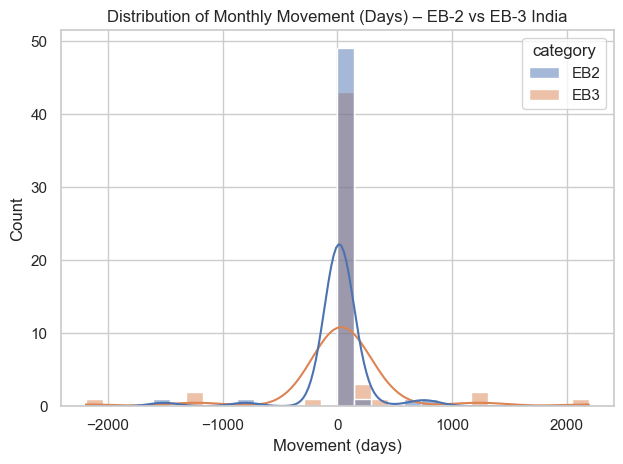

In [25]:
# Distribution of monthly movement
plt.figure()
sns.histplot(data=df_model, x="movement_days", hue="category", bins=30, kde=True)
plt.title("Distribution of Monthly Movement (Days) – EB-2 vs EB-3 India")
plt.xlabel("Movement (days)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


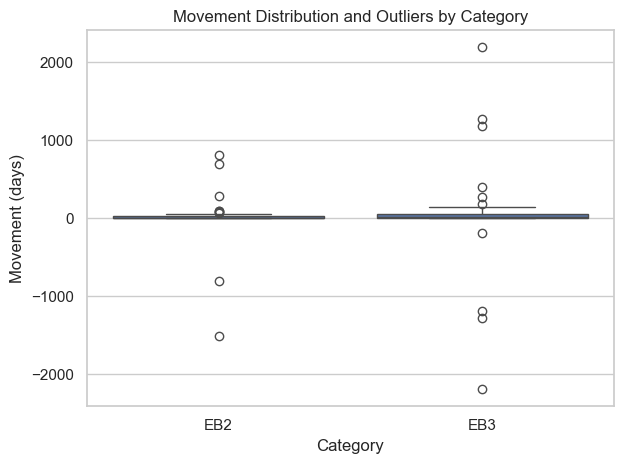

In [28]:
# Boxplot to inspect outliers
plt.figure()
sns.boxplot(data=df_model, x="category", y="movement_days")
plt.title("Movement Distribution and Outliers by Category")
plt.xlabel("Category")
plt.ylabel("Movement (days)")
plt.tight_layout()
plt.show()


In [30]:
# Assuming you already created df_model with movement_days like this:
# df_model = df_clean.sort_values(["category", "bulletin_date"]).reset_index(drop=True)
# df_model["cutoff_lag"] = df_model.groupby("category")["cutoff_date"].shift(1)
# df_model["movement_days"] = (df_model["cutoff_date"] - df_model["cutoff_lag"]).dt.days

# Now create lag and rolling features on df_model
df_model = df_model.sort_values(["category", "bulletin_date"]).reset_index(drop=True)

df_model["movement_lag1"] = df_model.groupby("category")["movement_days"].shift(1)
df_model["movement_lag2"] = df_model.groupby("category")["movement_days"].shift(2)
df_model["movement_roll3"] = (
    df_model.groupby("category")["movement_days"]
            .rolling(window=3)
            .mean()
            .reset_index(level=0, drop=True)
)

df_model = df_model.dropna(subset=["movement_days", "movement_lag1", "movement_lag2", "movement_roll3"]).copy()
df_model.head()


,bulletin_date,category_raw,cutoff_str,category,cutoff_date,cutoff_lag,movement_days,year,month,movement_lag1,movement_lag2,movement_roll3
2,2016-07-01,EB2-FA,1-Nov-04,EB2,2004-11-01,2004-10-01,31.0,2016,7,-1513.0,14.0,-489.333333
3,2016-08-01,EB2-FA,15-Nov-04,EB2,2004-11-15,2004-11-01,14.0,2016,8,31.0,-1513.0,-489.333333
4,2016-09-01,EB2-FA,22-Feb-05,EB2,2005-02-22,2004-11-15,99.0,2016,9,14.0,31.0,48.000000
5,2016-10-01,EB2-FA,15-Jan-07,EB2,2007-01-15,2005-02-22,692.0,2016,10,99.0,14.0,268.333333
6,2016-11-01,EB2-FA,1-Nov-07,EB2,2007-11-01,2007-01-15,290.0,2016,11,692.0,99.0,360.333333


In [31]:
# Encode category and define features/target
df_model["category_encoded"] = df_model["category"].map({"EB2": 0, "EB3": 1})

feature_cols = [
    "movement_lag1",
    "movement_lag2",
    "movement_roll3",
    "year",
    "month",
    "category_encoded"
]

X = df_model[feature_cols]
y = df_model["movement_days"]

df_model = df_model.sort_values("bulletin_date").reset_index(drop=True)
split_idx = int(len(df_model) * 0.8)

X_train = X.iloc[:split_idx]
y_train = y.iloc[:split_idx]
X_test = X.iloc[split_idx:]
y_test = y.iloc[split_idx:]

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (83, 6)
Test shape: (21, 6)


In [32]:
# Baseline RandomForest regression model
baseline_model = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

baseline_model.fit(X_train, y_train)
y_pred = baseline_model.predict(X_test)

mae_days = mean_absolute_error(y_test, y_pred)
mae_months = mae_days / 30

print(f"MAE (days): {mae_days:.2f}")
print(f"MAE (approx. months): {mae_months:.2f}")

MAE (days): 133.74
MAE (approx. months): 4.46


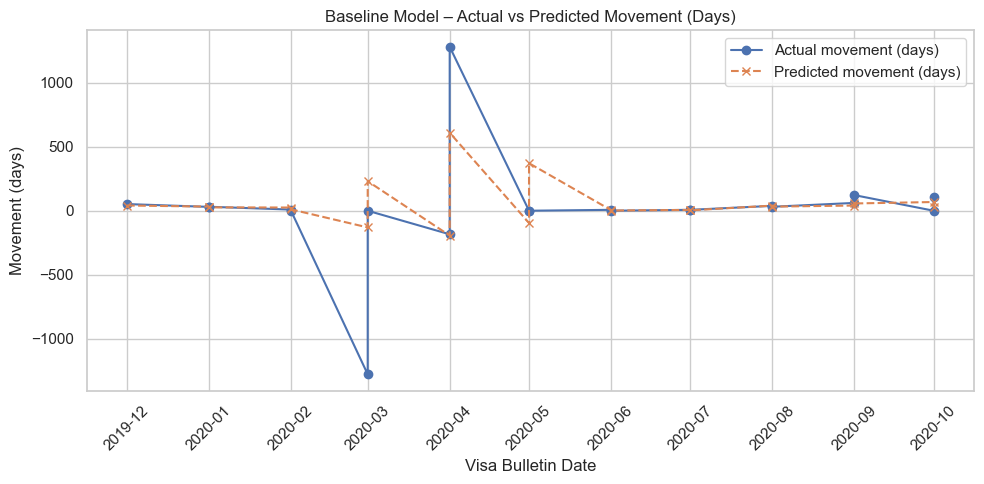

In [33]:
# Actual vs predicted plot
results = df_model.iloc[split_idx:].copy()
results["y_true"] = y_test.values
results["y_pred"] = y_pred

plt.figure(figsize=(10, 5))
plt.plot(results["bulletin_date"], results["y_true"], marker="o", label="Actual movement (days)")
plt.plot(results["bulletin_date"], results["y_pred"], marker="x", linestyle="--", label="Predicted movement (days)")
plt.title("Baseline Model – Actual vs Predicted Movement (Days)")
plt.xlabel("Visa Bulletin Date")
plt.ylabel("Movement (days)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

movement_roll3      0.461551
movement_lag1       0.407586
movement_lag2       0.072505
month               0.036001
year                0.017132
category_encoded    0.005224
dtype: float64


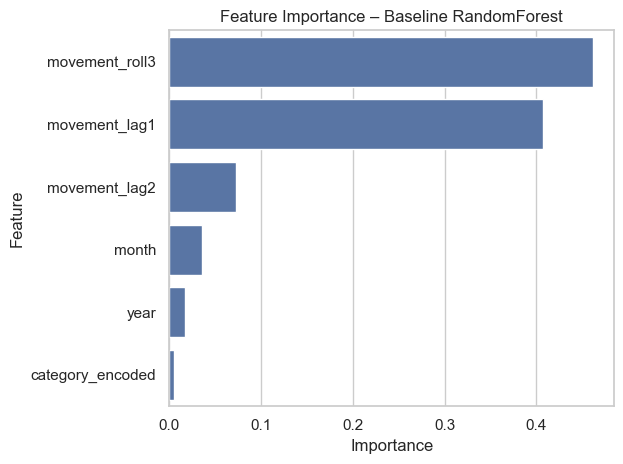

In [34]:
# Feature importance
importances = pd.Series(baseline_model.feature_importances_, index=feature_cols).sort_values(ascending=False)
print(importances)

plt.figure()
sns.barplot(x=importances.values, y=importances.index)
plt.title("Feature Importance – Baseline RandomForest")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

## Baseline Model Summary

- **Model:** RandomForestRegressor  
- **Target Variable:** `movement_days` — the month-to-month change (in days) of the Visa Bulletin cutoff date for EB-2 and EB-3 India.  
- **Key Features Used:**
  - `movement_lag1`, `movement_lag2` — previous 1–2 months of movement  
  - `movement_roll3` — 3-month rolling average  
  - Calendar features: `year`, `month`  
  - Encoded category (`EB2` = 0, `EB3` = 1)  

### Evaluation Metric: Mean Absolute Error (MAE)

MAE was selected because:

- It provides an intuitive interpretation: the average absolute prediction error in **days**.  
- It is more robust than RMSE to the sudden jumps and retrogressions that occur in Visa Bulletin data.  

**Model Performance:**

- **MAE (days):** 133.74  
- **MAE (approx. months):** 4.46  

The baseline Random Forest model captures some short-term patterns in movement but struggles with **policy-driven shocks** and the **non-linear volatility** inherent in EB-2/EB-3 India cutoff movements. These limitations are expected for a simple baseline model.

In the next phase of the capstone, more advanced models such as **XGBoost** and **LSTM** will be explored to better model temporal dependencies and irregular jumps.

